# Experiments for the paper

In [1]:
import jax, jax.numpy as jnp
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import math
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_enable_x64', True)

from src.stats.hmm import get_generative_model
from src.variational import get_variational_model
from src.training import SVITrainer


/home/mathis/.venvs/jax-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-23 15:44:34.903883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 15:44:34.903914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 15:44:34.903937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 15:44:35.355884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: 

In [2]:
def set_defaults(args):
    args.default_prior_mean = 0.0 # default value for the mean of Gaussian prior
    args.default_prior_base_scale = math.sqrt(0.1) # default value for the diagonal components of the covariance matrix of the prior
    args.default_transition_base_scale = math.sqrt(0.1) # default value for the diagonal components of the covariance matrix of the transition kernel
    args.default_transition_bias = 0.0
    args.default_emission_base_scale = math.sqrt(0.1)
    return args


def plot_x_true_against_x_pred(x_true, x_pred):
    dims = x_true.shape[-1]
    _ , axes = plt.subplots(dims, 1, figsize=(15,2*dims))
    for dim in range(dims):
        axes[dim].plot(x_true[:,dim], c='red', label='True')
        axes[dim].plot(x_pred[:,dim], c='green', label='Pred')
        axes[dim].legend()

def compute_rmse_x_true_against_x_pred(x_true, x_pred):
    rmse = jax.vmap(lambda x,y: jnp.mean(jnp.sqrt(jnp.mean((x-y)**2, axis=-1)), axis=0))
    print('RMSE:',rmse.tolist())


## Linear-Gaussian HMM 

In [3]:
date = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
# exp_path = os.path.join('experiments', date)
# os.makedirs(exp_path, exist_ok=True)

### Setting up data and generative model

In [4]:
key = jax.random.PRNGKey(0) # seed
p_args = argparse.Namespace() # will contain all configuration information for the generative model 
p_args.state_dim, p_args.obs_dim = 10,10
p_args.model = 'linear' 
p_args.seq_length = 500
p_args.emission_bias = False # no bias in the emission kernel, i.e. only Y_t = B X_t + noise
p_args.transition_bias = False # no bias in the transition kernel, i.e. only X_t = A X_{t-1} + noise
p_args.transition_matrix_conditionning = 'diagonal' # the transition matrix will be diagonal
p_args.range_transition_map_params = [0.8,0.99] # the diagonal values are constrained to [0.9 1]
p_args.parametrization = 'cov_chol' # parametrization of the covariance matrices 
p_args.num_seqs = 1 #
p_args = set_defaults(p_args) # setting default values for the covariances with realistic Signal to noise ratios

key, key_theta, key_sequences = jax.random.split(key, 3)
p, theta = get_generative_model(p_args, key_theta) # getting the model and its parameters 
print(theta)
# save_args(p_args, 'args', exp_path) # saving the params of the generative model
# save_params(theta, 'theta', exp_path) # saving the parameters
# jnp.save(os.path.join(exp_path, 'xs'), xs)
# jnp.save(os.path.join(exp_path, 'ys'), ys)

HMM.Params(prior={'_mean': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64), '_scale': {'cov_chol': Array([0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777],      dtype=float64)}}, transition=KernelParams(map={'w': Array([0.82542055, 0.96622884, 0.95448662, 0.87425585, 0.88901925,
       0.95008172, 0.95298186, 0.80430879, 0.86890732, 0.93455542],      dtype=float64)}, noise=Gaussian.NoiseParams(scale={'cov_chol': Array([0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
       0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777],      dtype=float64)})), emission=KernelParams(map={'w': Array([[0.72040887, 0.92914054, 0.21860484, 0.50405585, 0.62168075,
        0.02445033, 0.69191256, 0.63553277, 0.67298275, 0.85504665],
       [0.13338776, 0.13034457, 0.80627864, 0.06559457, 0.12846348,
        0.44986133, 0.7438845 , 0.51973879, 0.32196926, 0.47768569],
       [0.9597153 , 0.3579

In [5]:
xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     p_args.num_seqs, 
                                     p_args.seq_length,
                                     single_split_seq=False, # not sampling a sequence and splitting into subsequences
                                     load_from='', # not loading from external folder
                                     loaded_seq=False) # not loading sequences

### Setting up variational model and training parameters

In [6]:
q_args = argparse.Namespace() # will contain all configuration information for the variational model 
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim 
q_args.model = 'linear' 
q_args.emission_bias = False 
q_args.transition_bias = False 
q_args.transition_matrix_conditionning = 'diagonal' 
q_args.range_transition_map_params = [0.8,0.99] 
q_args.parametrization = 'cov_chol'
q_args = set_defaults(q_args) 
# sub_exp_path = os.path.join(exp_path, q_args.model)
# os.makedirs(sub_exp_path, exist_ok=True)
# save_args(p_args, 'args', sub_exp_path) # saving the params of the generative model
q = get_variational_model(q_args) # getting the corresponding model


### Learning in an offline setting

Num params: 150
Monitor ELBO is analytical.
USING ANALYTICAL ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:16<00:00, 59.70it/s]


Num params: 150
Monitor ELBO is analytical.
USING AUTODIFF ON BACKWARD BATCH ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:17<00:00, 56.99it/s]


Num params: 150
Monitor ELBO is analytical.
USING SCORE ELBO.
Using full gradients.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:48<00:00, 20.44it/s]


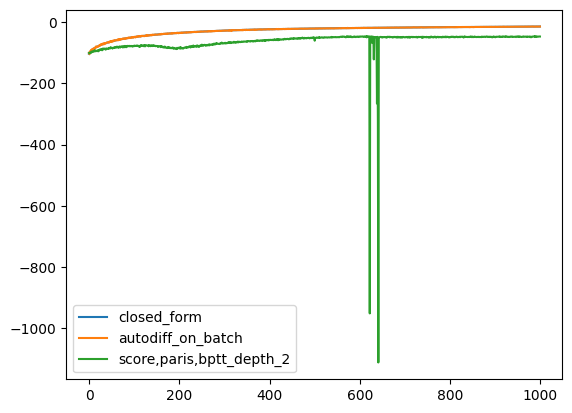

In [7]:
key = jax.random.PRNGKey(1)
for elbo_mode in ['closed_form', 'autodiff_on_batch', 'score,paris,bptt_depth_2']:
    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-3, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1000, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=2, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode=f'reset,{p_args.seq_length},1', 
                        elbo_mode=elbo_mode,
                        logging_type='basic_logging')


    key_init_params, key_montecarlo = jax.random.split(key, 2)
    fitted_variational_params, elbos = trainer.fit(key_init_params, 
                                    key_montecarlo, 
                                    data=(xs, ys), 
                                    log_writer=None, 
                                    args=None, 
                                    log_writer_monitor=None)

    elbo_for_all_epochs = elbos.flatten()
    plt.plot(elbo_for_all_epochs, label=elbo_mode)
plt.legend()

HMM.Params(prior={'_mean': Array([ 0.37104025, -0.19697516,  0.90621781, -0.34489087,  0.71392641,
        0.26648443,  0.3560936 ,  0.66179418,  1.07933043,  0.05097113],      dtype=float64), '_scale': {'cov_chol': Array([-0.59122607,  0.49275945, -0.9189722 ,  0.0729687 ,  0.19298024,
        0.17626724, -0.35691443, -0.34297625,  0.77274597, -0.79780544],      dtype=float64)}}, transition=KernelParams(map={'w': Array([1.11755934, 1.01849926, 1.11842859, 0.97618049, 1.21153869,
       0.8483765 , 1.28721226, 1.15019506, 1.24260985, 1.00096297],      dtype=float64)}, noise=Gaussian.NoiseParams(scale={'cov_chol': Array([ 0.67003603,  0.59685267,  0.44277799,  0.32570128,  0.5233021 ,
        0.35282013,  0.38972674,  0.61795394, -0.42826558,  0.56429707],      dtype=float64)})), emission=KernelParams(map={'w': Array([[ 0.94654084,  0.71649271,  0.334145  , -0.00664208,  0.7572555 ,
         0.8083876 ,  0.42803243,  0.83967936,  0.3841108 ,  0.98519277],
       [-0.07031161,  0.5906201

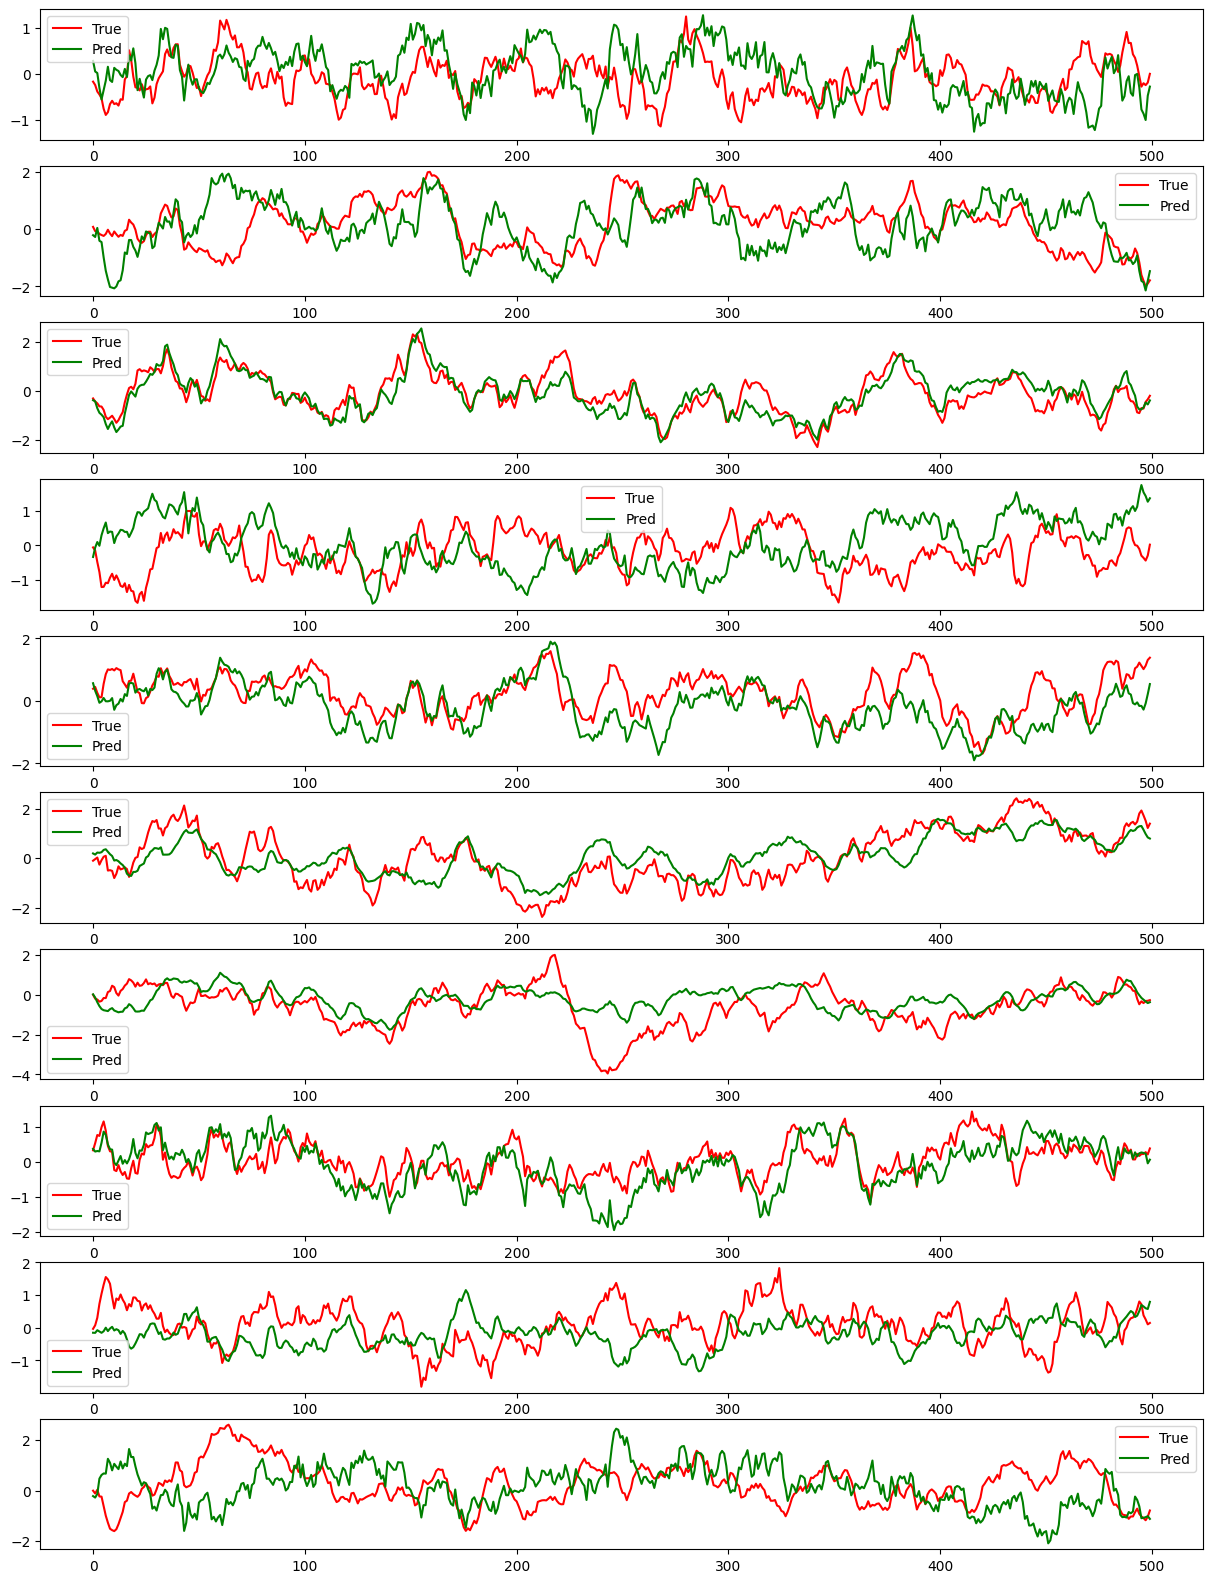

In [8]:
print(fitted_variational_params)
x_smoothed_kalman = p.smooth_seq(ys[0], theta)[0]
x_smoothed_variational = q.smooth_seq(ys[0], fitted_variational_params)[0]
plot_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)

### Streaming data

In [9]:
p_args.seq_length = 100_000 # keeping all previous settings except the sequence length

xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     num_seqs=1, 
                                     seq_length=p_args.seq_length,
                                     single_split_seq=False,
                                     load_from='')


elbo_mode = 'score,paris,bptt_depth_2'
trainer = SVITrainer(p=p,
                    theta_star=theta,
                    q=q,
                    optimizer='adam',
                    learning_rate=1e-5, 
                    optim_options='cst', # learning rate schedule
                    num_epochs=1, # number of full sweeps through the sequence
                    seq_length=p_args.seq_length,
                    num_samples=10, # number of monte carlo samples (or trajectories in the online case)
                    frozen_params='', # which parameters to hold fixed
                    num_seqs=p_args.num_seqs, 
                    training_mode=f'streaming,1,difference', # L_t - L_{t-1} / t
                    elbo_mode=elbo_mode,
                    logging_type='basic_logging')

key_init_params, key_montecarlo = jax.random.split(key, 2)
fitted_variational_params, elbos = trainer.fit(key_init_params, 
                                key_montecarlo, 
                                data=(xs, ys), 
                                log_writer=None, 
                                args=None, 
                                log_writer_monitor=None)

Num params: 150
Monitor ELBO is analytical.
USING SCORE ELBO.
Using full gradients.


Running for 100,000 iterations: 100%|██████████| 100000/100000 [00:45<00:00, 2217.36it/s]


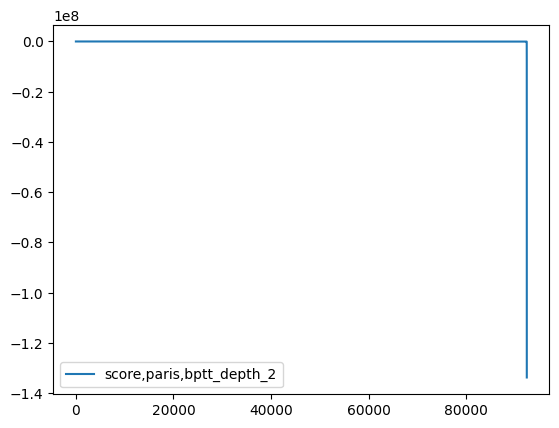

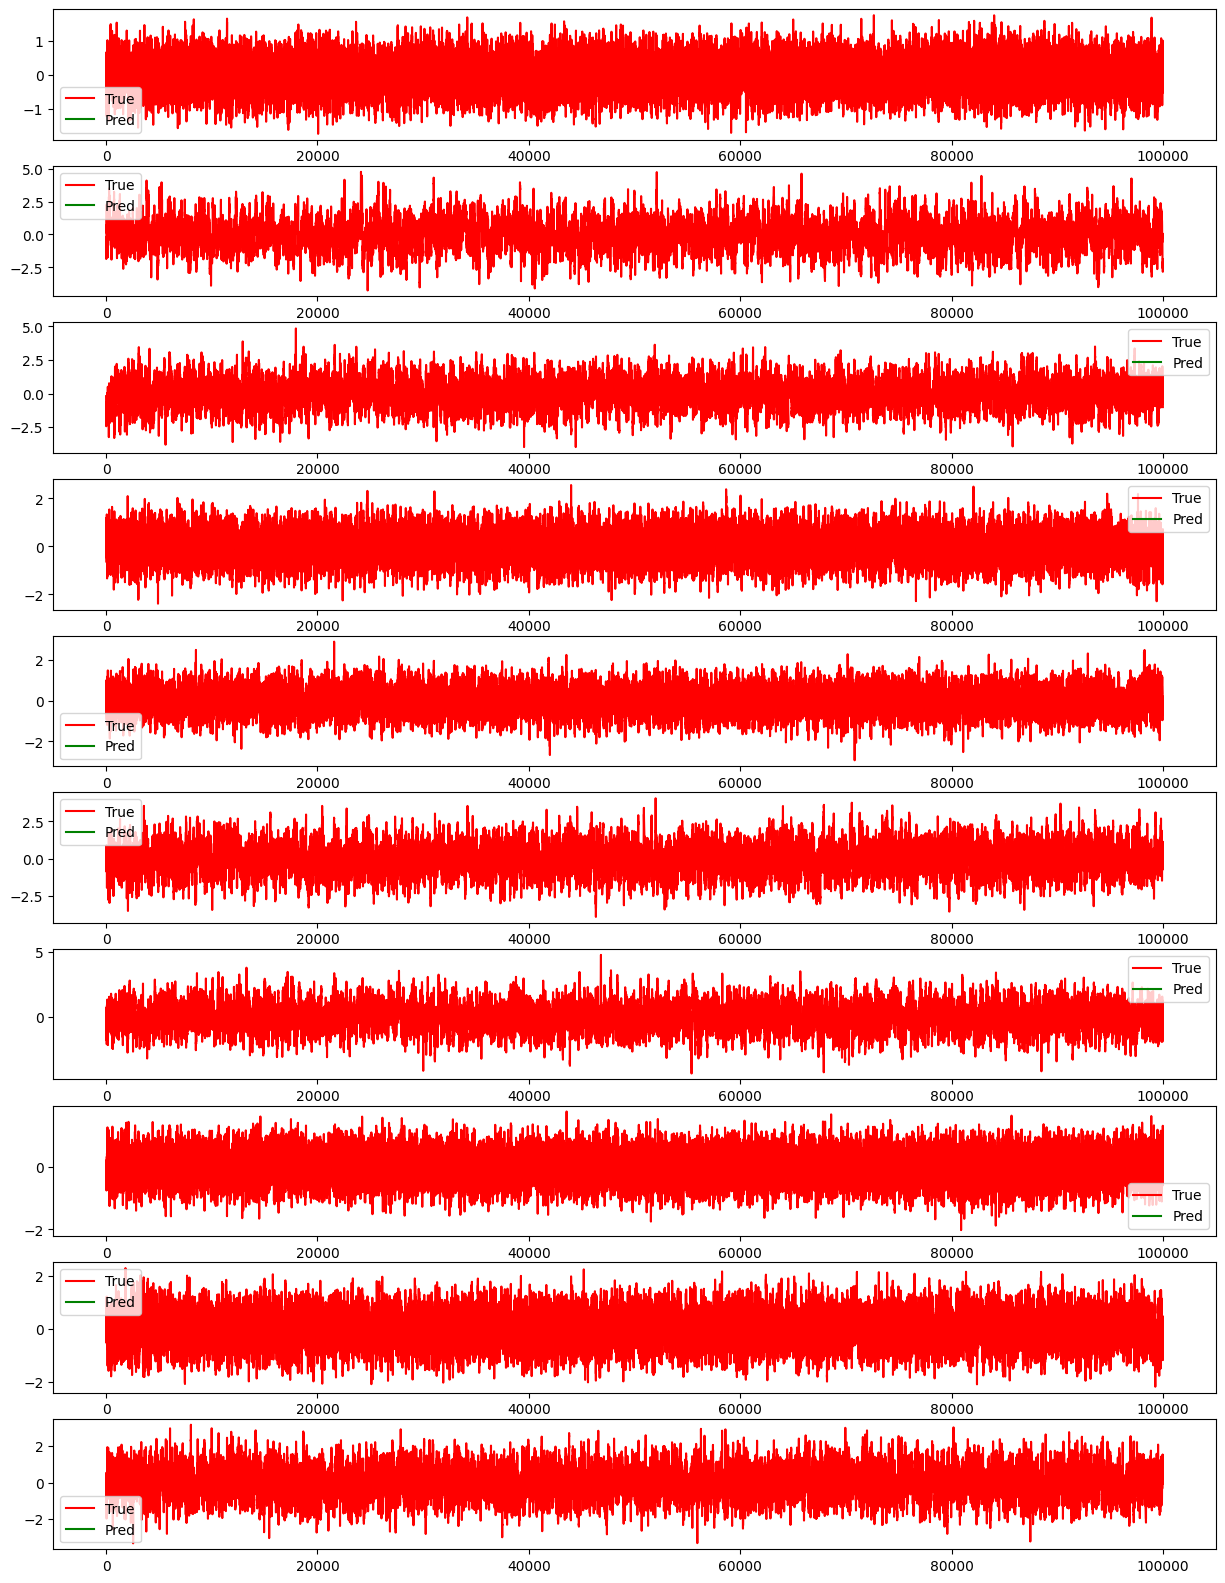

In [10]:
elbo_for_all_epochs = elbos.flatten()
plt.plot(elbo_for_all_epochs, label=elbo_mode)
plt.legend()
False
x_smoothed_kalman = p.smooth_seq(ys[0], theta)[0]
x_smoothed_variational = q.smooth_seq(ys[0], fitted_variational_params)[0]
plot_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)

## Chaotic RNN

### Streaming data

In [23]:
p_args = argparse.Namespace()

p_args.state_dim, p_args.obs_dim = 5,5 
p_args.model = 'chaotic_rnn' 
p_args.seq_length = 500
p_args.loaded_seq = True
p_args.load_from = 'data/crnn/2022-10-18_15-28-00_Train_run'
p_args.range_transition_map_params = [-1,1] # range of the components of the transition matrix
p_args.transition_matrix_conditionning = 'init_scale_by_dim' # constraint
p_args.default_transition_matrix = os.path.join(p_args.load_from, 'W.npy')

p_args.gamma = 2.5 # gamma for the chaotic rnn
p_args.tau = 0.025 # tau for the chaotic rnn
p_args.grid_size = 0.001 # discretization parameter for the chaotic rnn

p_args.emission_matrix_conditionning = 'diagonal'
p_args.range_emission_map_params = (-1,1)
p_args.default_emission_df = 2 # degrees of freedom for the emission noise
p_args.default_emission_matrix = 1.0 # diagonal values for the emission matrix
p_args.transition_bias = False 
p_args.emission_bias = False
p_args.num_seqs = 1 #

p_args.default_prior_mean = 0.0 # default value for the mean of Gaussian prior
p_args.default_prior_base_scale = 0.1 # default value for the diagonal components of the covariance matrix of the prior
p_args.default_transition_base_scale = 0.1 # default value for the diagonal components of the covariance matrix of the transition kernel
p_args.default_transition_bias = 0.0
p_args.default_emission_base_scale = 0.1
p_args.num_particles, p_args.num_smooth_particles = None, None

In [24]:
key = jax.random.PRNGKey(0)
key, key_params, key_sequences = jax.random.split(key, 3)
p, theta = get_generative_model(p_args, key_params)
xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     1, 
                                     p_args.seq_length,
                                     single_split_seq=False,
                                     load_from=p_args.load_from, 
                                     loaded_seq=p_args.loaded_seq)

Sequences loaded.


In [25]:
q_args = argparse.Namespace()
q_args.model = 'johnson_backward,8'
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim
q_args.transition_bias = False
q_args.emission_bias = False
layers = [int(nb) for nb in q_args.model.split(',')[-1].split('_')]
q_args.update_layers = (*layers,)
q_args.backwd_layers = 0
q_args.transition_matrix_conditionning = 'diagonal'
q_args.range_transition_map_params = (0.8, 1)
q_args.anisotropic = False
q_args.parametrization = 'cov_chol' # parametrization of the covariance matrices 

q_args = set_defaults(q_args)

q = get_variational_model(q_args)



Num params: 158
USING AUTODIFF ON BACKWARD BATCH ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:12<00:00, 79.28it/s]


Num params: 158
USING SCORE ELBO.
Using full gradients.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:29<00:00, 33.48it/s]


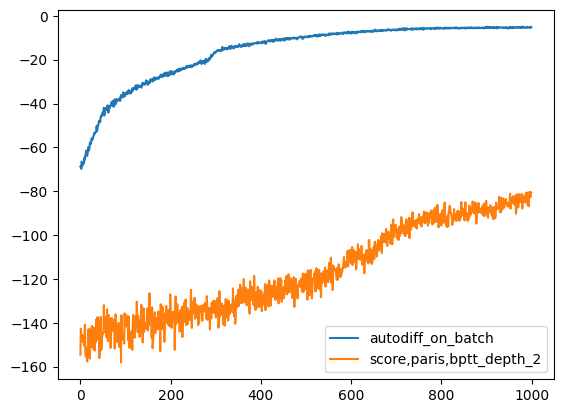

In [26]:
key = jax.random.PRNGKey(1)
for elbo_mode in ['autodiff_on_batch', 'score,paris,bptt_depth_2']:
    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-3, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1000, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=2, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode=f'reset,{p_args.seq_length},1', 
                        elbo_mode=elbo_mode,
                        logging_type='basic_logging')


    key_init_params, key_montecarlo = jax.random.split(key, 2)
    fitted_variational_params, elbos = trainer.fit(key_init_params, 
                                    key_montecarlo, 
                                    data=(xs, ys), 
                                    log_writer=None, 
                                    args=None, 
                                    log_writer_monitor=None)

    elbo_for_all_epochs = elbos.flatten()
    plt.plot(elbo_for_all_epochs, label=elbo_mode)
plt.legend()